<a href="https://colab.research.google.com/github/tommasomncttn/NAS4CNN/blob/main/Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing 

In [54]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

### Dataset 

In [12]:
class TensorizedDigits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode = "train", transforms = None, tensorized = True):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

        if tensorized:
          self.transforms = TensorizedDigits.tensorization_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        
        if True:
          sample_x, sample_y = self.transforms(sample_x, sample_y)
        

        return (sample_x, sample_y)

    @staticmethod
    def tensorization_transform(x, y):
        
        # reshape to get a valid input for a CNN
        sample_x = x.reshape(1, 8, 8)
        sample_y = y

        # transform it to torch tensor to move them to cuda
        if torch.cuda.is_available():

          sample_x = torch.from_numpy(sample_x).to("cuda")
          sample_y = np.array(y)
          sample_y = torch.from_numpy(sample_y).to("cuda")


        return sample_x, sample_y
    
    def visualize_datapoint(self, idx):

      x,y = self.__getitem__( idx)
      plt.imshow(x[0].cpu(), cmap="gray")
      plt.axis("off")
      plt.show()


### Module

In [75]:
class MultiConfigCNN(nn.Module):
    '''Conv2d → f(.) → Pooling → Flatten → Linear 1 → f(.) → Linear 2 → Softmax
    '''
    def __init__(self, cnn_i_N = 1, cnn_o_N = 8, cnn_k_size = 3, stride = 1, padding = 1, pool_k_size = 2, fnn_o_N = 10):
        super(MultiConfigCNN, self).__init__()

        self.cnn_i_N = cnn_i_N
        self.cnn_o_N = cnn_o_N
        self.cnn_k_size = cnn_k_size
        self.stride = stride
        self.padding = padding
        self.pool_k_size = pool_k_size
        self.fnn_o_N = fnn_o_N
        
        self.cnn =  nn.Conv2d(in_channels = cnn_i_N, out_channels = cnn_o_N, kernel_size = cnn_k_size, stride = stride, padding = padding)
        self.activation1 = nn.ReLU() # or sigmoid, tanh, softplus, elu
        self.pool = nn.MaxPool2d(kernel_size = pool_k_size) # or avg pool
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(in_features = self.compute_input_2_linear(), out_features = fnn_o_N)
        self.activation2 = nn.ReLU() # or sigmoid, tanh, softplus, elu
        self.linear2 = nn.Linear(in_features = fnn_o_N, out_features = 10)
        self.softmax = nn.LogSoftmax(dim=1)

        self.nll = nn.NLLLoss(reduction="none") 
    
    def compute_input_2_linear(self):

        # computing after convolution => [(W-K+2P)/S]+1
        after_cnn_channels = self.cnn_o_N
        after_cnn_height = after_cnn_width = ((8 - self.cnn_k_size + 2 * self.padding) / self.stride) + 1

        # computing after pooling => fixed values stride=kernel_dimension, padding=0, dilation=1 => formula at end of https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
        after_pool_height = after_pool_width = ((after_cnn_height - self.pool_k_size) / self.pool_k_size ) + 1

        # computing after flattening 

        return int(after_pool_height * after_pool_width * after_cnn_channels)

    def classify(self, log_prob):
        
        y_pred = torch.argmax(log_prob, dim = 1).long()        
        return y_pred

    def forward(self, x):
        
        x = self.cnn(x)
        x = self.activation1(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation2(x)
        x = self.linear2(x)
        log_prob = self.softmax(x)

        return log_prob


    def compute_loss(self, log_prob, y, reduction="avg"):

        loss = self.nll(log_prob, y)

        if reduction == "sum":
            return loss.sum()

        else:
            return loss.mean()

    def count_misclassified(self, predictions, targets):

        e = 1.0 * (predictions == targets)
        misclassified = (1.0 - e).sum().item()
        
        return misclassified

### Training and Validation Loop

In [121]:
def configure_optimizer(model, lr = 1e-3, wd = 1e-5):
  return torch.optim.Adamax(model.parameters(), lr=lr, weight_decay=wd)

In [143]:
def train_one_epoch(dataloader, model, optimizer, epoch_n = None):

    model.train()

    size = len(dataloader.dataset)
    total_loss = 0
    total_miss = 0
    train_step = 0

    for (X, y) in dataloader:

        train_step += 1

        # logits
        log_prob = model(X)

        # classification
        predictions = model.classify(log_prob)

        # misclassified 
        missclassified = model.count_misclassified(predictions, y)
        total_miss += missclassified

        # loss
        loss = model.compute_loss(log_prob, y, reduction = "sum")
        total_loss += loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    
    # compute epoch statistics
    avg_loss = total_loss / size
    avg_ce = total_miss / size
    
    
    print("")
    print(f" TRAINING => Results of epoch number {epoch_n}:")
    print('')
    print('    Average training loss: {0:.5f}'.format(avg_loss))
    print('    Average training classification error: {0:.5f}'.format(avg_ce))

    return avg_loss.item(), avg_ce


In [144]:
def evaluation_one_epoch(dataloader, model, optimizer, mode = "validation", epoch_n = None):

    model.eval()

    size = len(dataloader.dataset)
    total_loss = 0
    total_miss = 0
    val_step = 0


    with torch.no_grad():

      for (X, y) in dataloader:

          val_step += 1

          # logits
          log_prob = model(X)

          # classification
          predictions = model.classify(log_prob)

          # misclassified 
          missclassified = model.count_misclassified(predictions, y)
          total_miss += missclassified

          # loss
          loss = model.compute_loss(log_prob, y, reduction = "sum")
          total_loss += loss



    # compute epoch statistics
    avg_loss = total_loss / size
    avg_ce = total_miss / size
    
    if mode == "validation":

      
      print('')
      print('    Average validation loss: {:.5f}'.format(avg_loss))
      print('    Average validation classification error: {:.5f}'.format(avg_ce))


    else:

  
      print("")
      print(f"TESTING => Results of over test set")
      print('')
      print('    Average test loss: {:.5f}'.format(avg_loss))
      print('    Average test classification error: {0:.5f}'.format(avg_ce))


    return avg_loss.item(), avg_ce


In [151]:
def fit_epochs(training_loader, val_loader, test_loader, model, optimizer, n_epochs):

  train_loss_list = []
  train_ce_list = []
  val_loss_list = []
  val_ce_list = []
  test_loss_result = []
  test_ce_result = []

  for i in range(0,n_epochs):

    train_loss, train_ce =  train_one_epoch(dataloader = training_loader, model = model, optimizer = optimizer, epoch_n = i)
    train_loss_list.append(train_loss)
    train_ce_list.append(train_ce)

    val_loss, val_ce = evaluation_one_epoch(dataloader = val_loader, model = model, optimizer = optimizer, epoch_n = i)
    val_loss_list.append(val_loss)
    val_ce_list.append(val_ce)

  test_loss, test_ce = evaluation_one_epoch(dataloader = test_loader, model = model, optimizer = optimizer, mode = "test", epoch_n = i)
  test_loss_result.append(test_loss)
  test_ce_result.append(test_ce)


  result_dic = {"train_loss_list": train_loss_list, "train_ce_list": train_ce_list,"val_loss_list":val_loss_list, "val_ce_list":val_ce_list, "test_loss_result":test_loss_result, "test_ce_result":test_ce_result, "number_of_epochs" : n_epochs}

  return result_dic


In [158]:
def plot_results(results):
    # Extracting the data from the dictionary
    train_loss_list = results["train_loss_list"]
    train_ce_list = results["train_ce_list"]
    val_loss_list = results["val_loss_list"]
    val_ce_list = results["val_ce_list"]
    test_loss_result = results["test_loss_result"]
    test_ce_result = results["test_ce_result"]
    n_epochs = results["number_of_epochs"]

    # Plotting train loss
    plt.plot(range(1, n_epochs + 1), train_loss_list, label="Train Loss")

    # Plotting train classification error
    plt.plot(range(1, n_epochs + 1), train_ce_list, label="Train Classification Error")

    # Plotting validation loss
    plt.plot(range(1, n_epochs + 1), val_loss_list, label="Validation Loss")

    # Plotting validation classification error
    plt.plot(range(1, n_epochs + 1), val_ce_list, label="Validation Classification Error")

    # Plotting test loss
    plt.plot(range(1, n_epochs + 1), [test_loss_result] * n_epochs, label="Test Loss", linestyle="--")

    # Plotting test classification error
    plt.plot(range(1, n_epochs + 1), [test_ce_result] * n_epochs, label="Test Classification Error", linestyle="--")

    # Set plot labels and title
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Classification Error")
    plt.title("Training and Evaluation Results")

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()


### Inference 

In [153]:
# Initialize training, validation and test sets.
train_data = TensorizedDigits(mode="train")
val_data = TensorizedDigits(mode="val")
test_data = TensorizedDigits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [154]:
cnn = MultiConfigCNN().to("cuda")

In [155]:
opt = configure_optimizer(cnn)

In [156]:
results = fit_epochs(training_loader, val_loader, test_loader, model = cnn, optimizer = opt, n_epochs = 20)


 TRAINING => Results of epoch number 0:

    Average training loss: 2.46446
    Average training classification error: 0.88600

    Average validation loss: 2.21944
    Average validation classification error: 0.87429

 TRAINING => Results of epoch number 1:

    Average training loss: 2.19231
    Average training classification error: 0.87900

    Average validation loss: 2.16890
    Average validation classification error: 0.86857

 TRAINING => Results of epoch number 2:

    Average training loss: 2.13413
    Average training classification error: 0.85600

    Average validation loss: 2.10295
    Average validation classification error: 0.83714

 TRAINING => Results of epoch number 3:

    Average training loss: 2.07219
    Average training classification error: 0.80500

    Average validation loss: 2.04231
    Average validation classification error: 0.75429

 TRAINING => Results of epoch number 4:

    Average training loss: 2.01279
    Average training classification error: 0.71

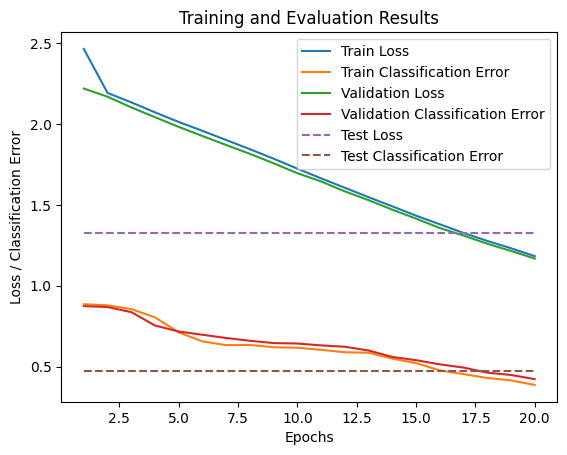

In [159]:
plot_results(results)